In [4]:
import sys
import os
import torch
import json
sys.path.append('..')
CONTENT_PATH = "/home/yifan/0ExpMinist/Default/01"
VIS_METHOD = "DVI" # DeepVisualInsight
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]
CLASSES = config["CLASSES"]

Epoch = 6

import Model.model as subject_model
# Training parameter (subject model)
GPU_ID = config["GPU"]
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

model = eval("subject_model.{}()".format(NET))

model_location = os.path.join(CONTENT_PATH, "Model", "Epoch_{:d}".format(Epoch), "subject_model.pth")
model.load_state_dict(torch.load(model_location, map_location=torch.device("cpu")))
model.to(DEVICE)
model.eval()



ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
import torch.nn.functional as F
from singleVis.data import NormalDataProvider
from singleVis.utils import *
data_provider = NormalDataProvider(CONTENT_PATH, model, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
test_data = data_provider.test_representation(Epoch)
labels = data_provider.test_labels(Epoch)  # Shape: (10000,)
probabilities = data_provider.get_pred(Epoch, test_data)

Finish initialization...
/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json


100%|██████████| 50/50 [00:00<00:00, 13897.63it/s]


In [3]:
from torch import nn
# Convert probabilities to logits
logits = torch.log_softmax(torch.Tensor(probabilities), dim=1)

# Define temperature scaling class
class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x):
        return x / self.temperature

# Apply temperature scaling
temperature_scaled_logits = TemperatureScaling()(logits)
calibrated_probabilities = torch.softmax(temperature_scaled_logits, dim=1)

# Evaluate calibration performance if needed

# Obtain calibrated predictions
_, predicted_labels = calibrated_probabilities.max(dim=1)

In [6]:
# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
save_dir = os.path.join(data_provider.content_path, "imgptDVI")
# Define visualization models
from singleVis.SingleVisualizationModel import VisModel

vismodel = VisModel(ENCODER_DIMS, DECODER_DIMS)
from singleVis.projector import DVIProjector

# Define Projector
projector = DVIProjector(vis_model=vismodel, content_path=CONTENT_PATH, vis_model_name='dvi', device=DEVICE) 
DATASET = config["DATASET"]
# from singleVis.visualizer_test import visualizer
# vis = visualizer(data_provider, data_provider.test_representation(Epoch), projector, 200,[],'tab10')
# vis.savefig(Epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, Epoch, 'test')))

2023-07-08 03:50:52.317146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 03:50:52.853195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-08 03:50:52.853240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-08 03:50:52.853244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Successfully load the DVI visualization model for iteration 6
Computing decision regions ...
Successfully load the DVI visualization model for iteration 6
Successfully load the DVI visualization model for iteration 6


100%|██████████| 200/200 [00:00<00:00, 9682.81it/s]


/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json


100%|██████████| 50/50 [00:00<00:00, 14253.73it/s]


Successfully load the DVI visualization model for iteration 6


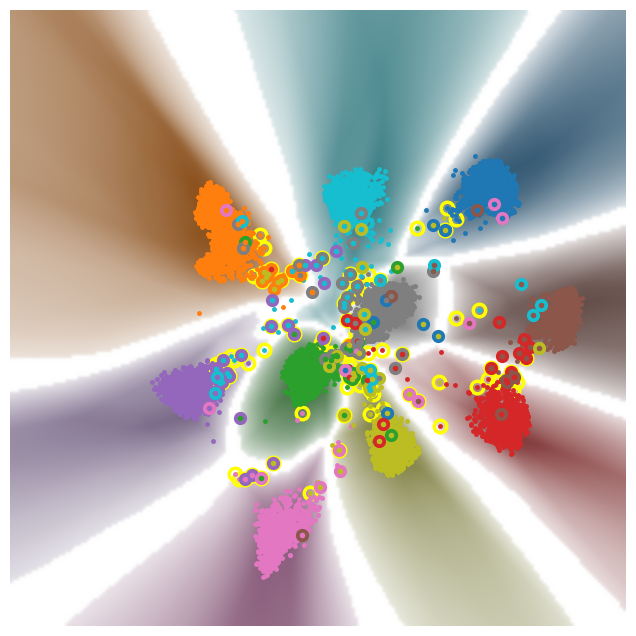

In [5]:
# Define Projector
projector = DVIProjector(vis_model=vismodel, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE) 
DATASET = config["DATASET"]
from singleVis.visualizer_test import visualizer
vis = visualizer(data_provider, data_provider.test_representation(Epoch), projector, 200,[],'tab10')
vis.savefig(Epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, Epoch, 'test')))

Successfully load the DVI visualization model for iteration 6
Computing decision regions ...
Successfully load the DVI visualization model for iteration 6
Successfully load the DVI visualization model for iteration 6


100%|██████████| 200/200 [00:00<00:00, 9991.20it/s]


temperature -744.5812377929688
mesh_preds (40000, 10)
/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json


100%|██████████| 50/50 [00:00<00:00, 9752.38it/s]

Successfully load the DVI visualization model for iteration 6


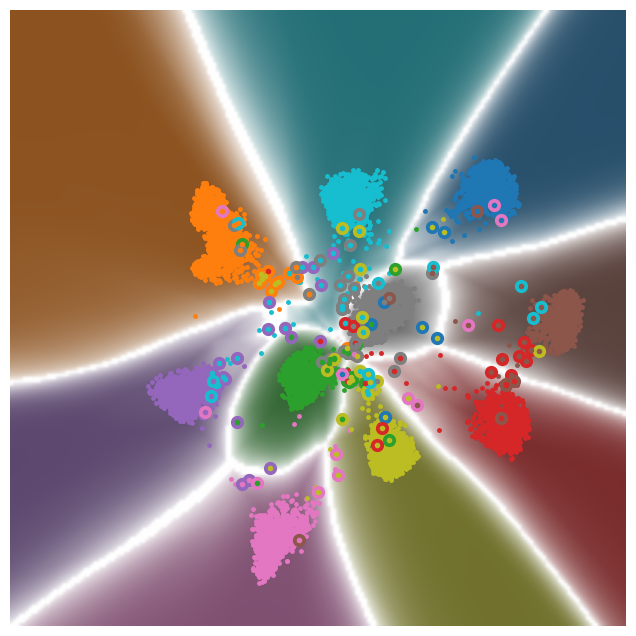

In [12]:
from singleVis.visualizer_cic import visualizer
# Define Projector
projector = DVIProjector(vis_model=vismodel, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE) 
DATASET = config["DATASET"]
# from singleVis.visualizer_test import visualizer
vis = visualizer(data_provider, data_provider.test_representation(Epoch), projector, 200,[],'tab10')
vis.savefig(Epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, Epoch, 'test')))

In [7]:
# pred_Res = data_provider.get_pred(Epoch, test_data).argmax(1)
# incorrect_prediction_class = []
# incorrect_indicates = []
# for i in range(10000):
#     if labels[i] != pred_Res[i]:
#         incorrect_prediction_class.append(pred_Res[i])
#         incorrect_indicates.append(i)

pred_Res = data_provider.get_pred(Epoch, test_data).argmax(1)
incorrect_prediction_class = []
incorrect_indicates = []
need_adjust = []
predction = data_provider.get_pred(Epoch, test_data)
from scipy.special import softmax
scores = np.amax(softmax(predction, axis=1), axis=1)
print(scores)

for i in range(10000):
    if labels[i] != pred_Res[i]:
        incorrect_prediction_class.append(pred_Res[i])
        incorrect_indicates.append(i)
        if scores[i] > 0.8:
            need_adjust.append(i)



100%|██████████| 50/50 [00:00<00:00, 13861.80it/s]

[0.99778086 0.999448   0.99179083 ... 0.99943167 0.9755228  0.99211717]


Successfully load the DVI visualization model for iteration 6
Computing decision regions ...
Successfully load the DVI visualization model for iteration 6
Successfully load the DVI visualization model for iteration 6


100%|██████████| 200/200 [00:00<00:00, 9404.48it/s]
../singleVis/visualizer_test.py:242: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.test_representation(epoch)[self.indicates]
../singleVis/visualizer_test.py:243: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.test_labels(epoch)[self.indicates]
../singleVis/visualizer_test.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json
/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json


100%|██████████| 1/1 [00:00<00:00, 3761.71it/s]

Successfully load the DVI visualization model for iteration 6


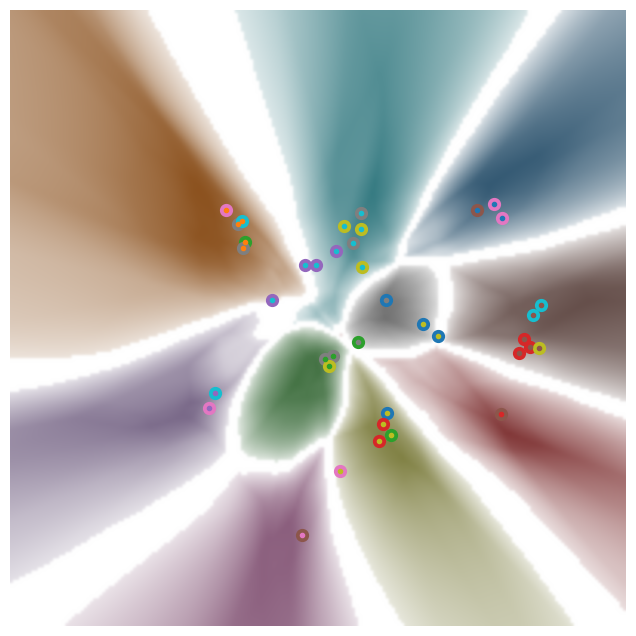

In [8]:
from singleVis.visualizer_cca import visualizer
# Define Projector
projector = DVIProjector(vis_model=vismodel, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE) 
DATASET = config["DATASET"]
vis = visualizer(data_provider, data_provider.test_representation(Epoch), projector, 200,[need_adjust],'tab10')
vis.savefig(Epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, Epoch, 'test')))

Successfully load the DVI visualization model for iteration 6
Computing decision regions ...
Successfully load the DVI visualization model for iteration 6
Successfully load the DVI visualization model for iteration 6


100%|██████████| 200/200 [00:00<00:00, 10057.08it/s]
../singleVis/visualizer_test.py:242: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.test_representation(epoch)[self.indicates]
../singleVis/visualizer_test.py:243: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.test_labels(epoch)[self.indicates]
../singleVis/visualizer_test.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the futur

/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json
/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json


100%|██████████| 1/1 [00:00<00:00, 5041.23it/s]

Successfully load the DVI visualization model for iteration 6


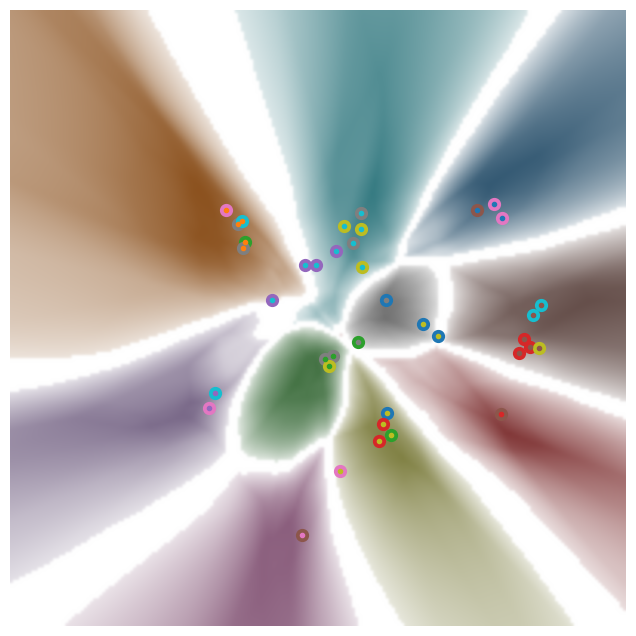

In [9]:
from singleVis.visualizer_test import visualizer
# Define Projector
projector = DVIProjector(vis_model=vismodel, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE) 
DATASET = config["DATASET"]
from singleVis.visualizer_test import visualizer
vis = visualizer(data_provider, data_provider.test_representation(Epoch), projector, 200,[need_adjust],'tab10')
vis.savefig(Epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, Epoch, 'test')))

In [23]:
len(need_adjust)

39

In [17]:
len(incorrect_indicates)

126

In [31]:
import torch
from torch import nn
import torch.optim as optim
wrong_test_data = data_provider.test_representation(Epoch)[[need_adjust]]

# Assuming you have the original representations stored in test_data
original_representations = torch.Tensor(wrong_test_data)

# Define a separate calibration model
calibration_model = nn.Sequential(
    nn.Linear(original_representations.shape[1], 512),
    nn.Softmax(dim=1)
)

# Define the criterion to minimize the probability of the incorrect prediction
criterion = nn.CrossEntropyLoss()

# Set the target class as the one predicted incorrectly
target_class = incorrect_prediction_class

# Define the perturbation variable
perturbation = nn.Parameter(torch.zeros_like(original_representations))

# Set up the optimizer
optimizer = optim.Adam([perturbation], lr=0.01)

# Number of optimization steps
num_steps = 1000

# Perform optimization to find the perturbation
for step in range(num_steps):
    optimizer.zero_grad()

    # Add the perturbation to the original representations
    perturbed_representations = original_representations + perturbation

    # Get the predictions and probabilities from the calibration model
    probabilities = calibration_model(perturbed_representations)
    _, predicted_classes = torch.max(probabilities, dim=1)

    # Calculate the loss as the negative probability of the target class
    loss = -probabilities[:, target_class].mean()

    # Backpropagate and update the perturbation
    loss.backward()
    optimizer.step()

# Obtain the new representations by adding the optimized perturbation
new_representations = original_representations + perturbation
new_all = data_provider.test_representation(Epoch)
k=0
for i in range(len(need_adjust)):
    
    index = incorrect_indicates[i]
    new_all[index] = new_representations[k].detach().numpy() 
    k = k + 1

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


Successfully load the DVI visualization model for iteration 6
Computing decision regions ...
Successfully load the DVI visualization model for iteration 6
Successfully load the DVI visualization model for iteration 6


100%|██████████| 200/200 [00:00<00:00, 9325.13it/s]
../singleVis/visualizer_test.py:242: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.test_representation(epoch)[self.indicates]
../singleVis/visualizer_test.py:243: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.test_labels(epoch)[self.indicates]
../singleVis/visualizer_test.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json
/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json


100%|██████████| 1/1 [00:00<00:00, 4529.49it/s]


Successfully load the DVI visualization model for iteration 6


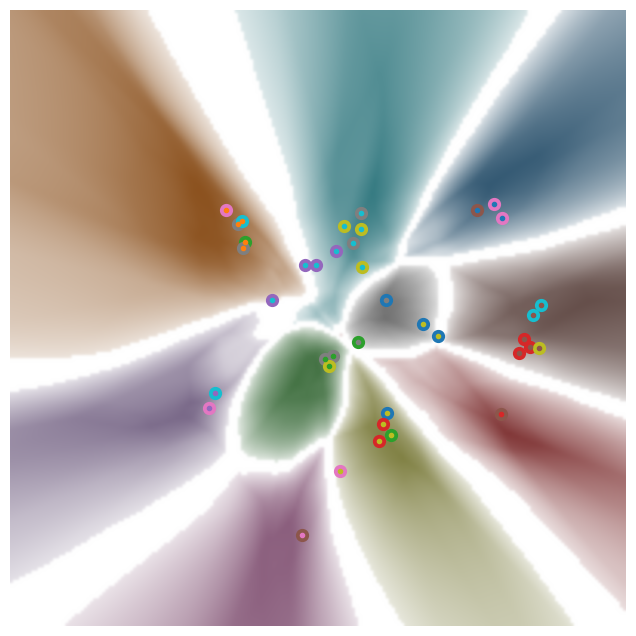

In [27]:
projector = DVIProjector(vis_model=vismodel, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE) 
from singleVis.visualizer_test import visualizer
vis = visualizer(data_provider, data_provider.test_representation(Epoch), projector, 100,[need_adjust],'tab10')
vis.savefig(Epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, Epoch, 'test')))

Successfully load the DVI visualization model for iteration 6
Computing decision regions ...
Successfully load the DVI visualization model for iteration 6
Successfully load the DVI visualization model for iteration 6


100%|██████████| 50/50 [00:00<00:00, 13425.21it/s]


/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json
/home/yifan/0ExpMinist/Default/01/Model/Epoch_6/test_index.json


100%|██████████| 1/1 [00:00<00:00, 4076.10it/s]

Successfully load the DVI visualization model for iteration 6


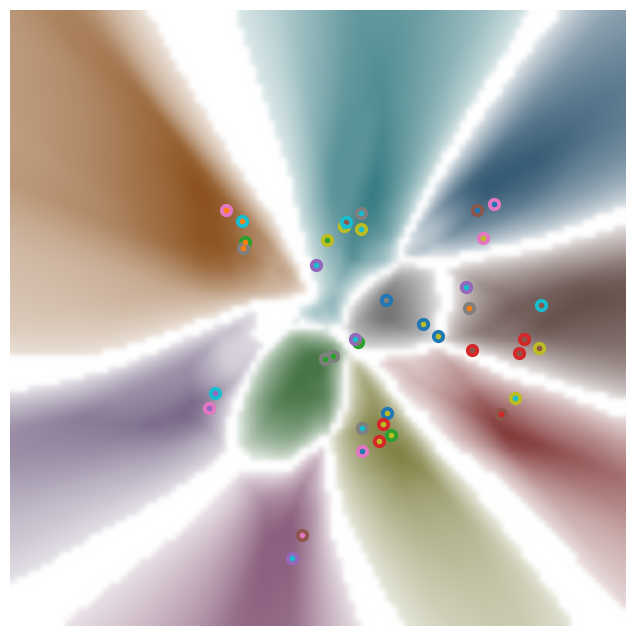

In [32]:
projector = DVIProjector(vis_model=vismodel, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE) 

vis = visualizer(data_provider, new_all, projector, 100,[need_adjust],'tab10')
vis.savefig(Epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, Epoch, 'test')))

In [10]:
testing_data_path = os.path.join(CONTENT_PATH, "Testing_data")
testing_data = torch.load(os.path.join(testing_data_path, "testing_dataset_data.pth"),
                                       map_location="cpu")
testing_data = testing_data.to(DEVICE)

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Convert your data and labels into PyTorch tensors
data = torch.Tensor(testing_data)
labels = torch.Tensor(labels)

# Split your data into training set and validation set
data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create TensorDataset for training and validation
train_dataset = TensorDataset(data_train, labels_train)
valid_dataset = TensorDataset(data_val, labels_val)

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


In [15]:
from torch.optim import SGD
from torch.nn import functional as F

class TemperatureScaling(torch.nn.Module):
    def __init__(self, model):
        super(TemperatureScaling, self).__init__()
        self.model = model
        self.temperature = torch.nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=1)
        # Take log-probabilities
        log_probs = torch.log(probs)
        return log_probs / self.temperature

    def calibrate(self, valid_loader):
        self.cuda()
        self.model.eval()
        nll_criterion = torch.nn.NLLLoss().cuda()
        optimizer = SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        for inputs, labels in valid_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            scaled_logits = self.forward(inputs)
            loss = nll_criterion(scaled_logits, labels)
            loss.backward()
            optimizer.step()


# Create a loader for your validation set
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Create the model
ts_model = TemperatureScaling(model)

from torch.utils.data import DataLoader

# Let's assume you have a validation Dataset `valid_dataset`
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
# Calibrate the model
ts_model.calibrate(valid_loader)

# Save the new model
torch.save(ts_model.state_dict(), 'model_new.pth')


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'